In [1]:
import pandas as pd
import numpy as np
import scipy.io
import re
import sys
import warnings
import pickle

In [2]:
import pickle
from IPython.core.display import display, HTML, Markdown

/tmp/ipykernel_25391/659417397.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [3]:
from mvpa2.datasets.mri import fmri_dataset

Failed to import duecredit due to No module named 'duecredit'
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):


In [4]:
class BehavioralDataNotFoundForBrainDataException(Exception):
    """Behavioral data could not be matched to a subject."""
    pass

In [5]:
from nilearn.masking import unmask

Replicating earlier work on mvpa. Try not to overly complicate it--the main point is just to verify we get similar results on a different package to validate prior work. ANd we are primarily interested in validating the very high cross-validation results I got with nltools. Should aim for readable code.


Version 5 uses scikit-learn directly, bypassing mvpa2's framework altogether. We also implement a 'forced choice' scorer.

In [6]:
from visualization import visualize_corr
import mvpa2

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/visualization.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [7]:
import sys
import os

sys.path.append(os.path.abspath("../../ml/"))


## Load

In [8]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [9]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [10]:
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]
exclude_subjects = ['DEV061','DEV185','DEV187','DEV189','DEV190','DEV192','DEV198','DEV203','DEV220','DEV221']
train_subjs = test_train_df.loc[test_train_df.SplitGroup=='Train','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [11]:
train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [12]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt_2022_02_26.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

We probably actually want to start the pipeline from the betas rather than loading from pickle. to be continued...

In [13]:
from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

## new code

In [14]:
from mvpa_sst_utils import *

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/mvpa_sst_utils.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown
/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/outlier_detection.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


In [15]:
from sklearn.model_selection import LeaveOneGroupOut

In [16]:
def remove_selected_outliers_mvpa_tesq_study(
    ind_div_combined,
    show_plot=False,
    neural_measures = ['CorGo_ln_inv_pred_prob_CorrectGo','CorStop_ln_inv_pred_prob_CorrectStop']):
    idc_outliers_removed = remove_selected_outliers(ind_div_combined,
    ['BFI_extraversion','RMQ_locomotion','ses_aggregate','PLAN_cognitive_strategies',
     'SST_SSRT','BIS_11','BSCS','TESQ_E_suppression', 'TESQ_E_avoidance_of_temptations', 
     'TESQ_E_goal_deliberation', 'TESQ_E_controlling_temptations', 'TESQ_E_distraction',
     'TESQ_E_goal_and_rule_setting','TESQ_E_sum','EDM','RS','TRSQ','ROC_Crave_Regulate_Minus_Look',
     'SRHI_unhealthy','cancer_promoting_minus_preventing_FFQ','bf_1'] + neural_measures,
    show_plot=show_plot)
    return(idc_outliers_removed)

In [17]:
from outlier_detection import *

In [18]:
from sklearn.svm import SVC
#from mvpa2.measures.base import CrossValidation
#from mvpa2.clfs.meta import NFoldPartitioner
#from mvpa2.clfs.svm import LinearCSVMC
from sklearn.calibration import CalibratedClassifierCV


In [19]:
from sklearn.model_selection import LeaveOneGroupOut

In [20]:
from generic_utils import *

## whole brain

Now let's scale that up to the full dataset.

## masks

We get the same file this time, but we apply a mask before doing learning.

In [21]:
## additional masks

all_masks = get_all_masks(ml_data_folderpath)

In [22]:
for mask_name in all_masks['mask_name']:
#    mask_value = all_masks[mask_name]
    print(mask_name,end=", ")

planning_association-test_z_FDR_0.01, executive function_association-test_z_FDR_0.01, response inhibition_association-test_z_FDR_0.01, inhibition_association-test_z_FDR_0.01, error_association-test_z_FDR_0.01, harvardoxford-cortical_prob_Frontal Orbital Cortex, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis, 

Next to do:
1. Consider re-implementing LinearSVM and getting similarity rather than this probability measure
2. Visualize for all the other values.

Now we've decoupled the learner from the framework where we apply it, we can pass in any arbitrary learner. It just has to output:

1. predictions 
2. prediction confidence 
3. the classifier itself

### Re-implementing v3

This is a useful sanity check, becuase it's helpufl to try and explain why we're doing so much  better than rpeviously.

In [23]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)


In [24]:
linear_results_with_similarity = do_forced_choice(
    Brain_Data_allsubs,
    get_predict_and_prob=do_LinearSVC)

.................................................................................

In [26]:
LinearSVC_correlation_wholebrain = linear_results_with_similarity

In [27]:
forced_choice_results = linear_results_with_similarity

In [28]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

In [29]:
forced_choice_results['sample_wise']

,chunks,target_y,pred_y,pred_y_forced_choice,pred_prob_CorrectGo,pred_prob_CorrectStop
0,DEV005_1,CorrectGo,CorrectGo,CorrectStop,0.050014,-0.050014
1,DEV005_1,CorrectStop,CorrectGo,CorrectGo,0.071863,-0.071863
0,DEV006_1,CorrectGo,CorrectGo,CorrectGo,0.097374,-0.097374
1,DEV006_1,CorrectStop,CorrectGo,CorrectStop,-0.002773,0.002773
0,DEV010_1,CorrectGo,CorrectGo,CorrectGo,0.036757,-0.036757
...,...,...,...,...,...,...
1,DEV216_1,CorrectStop,CorrectStop,CorrectStop,-0.161358,0.161358
0,DEV217_1,CorrectGo,CorrectGo,CorrectGo,0.055084,-0.055084
1,DEV217_1,CorrectStop,CorrectStop,CorrectStop,-0.002729,0.002729
0,DEV218_1,CorrectGo,CorrectGo,CorrectGo,0.030549,-0.030549


In [30]:
(prediction, forced_choice_prediction)

(0.7962962962962963, 0.9876543209876543)

Because this uses similarity, it doesn't make sense to talk about mean absolute error; we're not calculating a percent probability here. We could do some other figure derived from summing the similarity across the CS and CG items, then working out a proportion, but that would not be comparable to the mean absolute error reported below.

An alternative is to use SVM as below, but use the linear kernel instead of the default, rbf.

In [31]:


def do_LinearSVC_proba(train_X,train_y,test_X,test_y):
    sklearn_clf = SVC(kernel='linear',probability=True)

    #create the classifier with a probability function
    #https://mmuratarat.github.io/2019-10-12/probabilistic-output-of-svm#:~:text=SVMs%20don't%20output%20probabilities,the%20output%20to%20class%20probabilities.&text=For%20many%20problems%2C%20it%20is,of%20certainty%20about%20the%20answer.
    #we don't need this I'm doing my own probability estimate
    #hmmm, is this why the model is performing so well? the tuning?
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_clf.fit(train_X, train_y)

    #get the _probability_ we fall into each class
    predict_y_prob = sklearn_clf.predict_proba(test_X)
    predict_y = sklearn_clf.predict(test_X)
    return(predict_y,predict_y_prob,sklearn_clf)


The bigger differnce bwteen these methods (apart from the different kernel) is that one has use a pearson's correlation of each image with the mask, and that's what we are using to get the `pred_y_forced_choice`. It's methodologically questionable, so, considering it clashes with below, we probably shouldn't proceed with it. We might want to try a linear kernel with a real probability prediction, as below, to see what that gets us.

In [32]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

linear_results_with_similarity = do_forced_choice(
    Brain_Data_allsubs,
    get_predict_and_prob=do_LinearSVC_proba)

LinearSVC_correlation_wholebrain = linear_results_with_similarity
forced_choice_results = linear_results_with_similarity
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

.................................................................................

In [33]:
forced_choice_results['sample_wise']['error']=None

In [34]:
pred_prob_CG = forced_choice_results['sample_wise'].pred_prob_CorrectGo
target_is_CG = forced_choice_results['sample_wise'].target_y=="CorrectGo"
error = np.abs(target_is_CG-pred_prob_CG) #calculate absolute error
forced_choice_results['sample_wise']['error'] = error
mean_absolute_error = error.mean()

In [35]:
(prediction, forced_choice_prediction, mean_absolute_error)

(0.8271604938271605, 0.9876543209876543, 0.25608929144250314)

When this finishes, we can decide whether we still think the mean_absolute_error is performing (a) OK and (b) different from that below. Then we can proceed with waht we want to do with this analysis.

At the risk of 'overfitting' to this dataset, I think I'll proceed with this kernel and see how we go with the rest of the data. But in the meantime, we might try one or two more kernels.

In [37]:
def do_LinearSVC_proba(train_X,train_y,test_X,test_y,svc_kernel='linear'):
    sklearn_clf = SVC(kernel=svc_kernel,probability=True)

    #create the classifier with a probability function
    #https://mmuratarat.github.io/2019-10-12/probabilistic-output-of-svm#:~:text=SVMs%20don't%20output%20probabilities,the%20output%20to%20class%20probabilities.&text=For%20many%20problems%2C%20it%20is,of%20certainty%20about%20the%20answer.
    #we don't need this I'm doing my own probability estimate
    #hmmm, is this why the model is performing so well? the tuning?
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_clf.fit(train_X, train_y)

    #get the _probability_ we fall into each class
    predict_y_prob = sklearn_clf.predict_proba(test_X)
    predict_y = sklearn_clf.predict(test_X)
    return(predict_y,predict_y_prob,sklearn_clf)

def do_LinearSVC_proba_poly(train_X,train_y,test_X,test_y):
    return(do_LinearSVC_proba(train_X,train_y,test_X,test_y,svc_kernel='poly'))

def do_LinearSVC_proba_sigmoid(train_X,train_y,test_X,test_y):
    return(do_LinearSVC_proba(train_X,train_y,test_X,test_y,svc_kernel='sigmoid'))

In [38]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

linear_results_with_similarity = do_forced_choice(
    Brain_Data_allsubs,
    get_predict_and_prob=do_LinearSVC_proba_poly)

LinearSVC_correlation_wholebrain = linear_results_with_similarity
forced_choice_results = linear_results_with_similarity
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

forced_choice_results['sample_wise']['error']=None

pred_prob_CG = forced_choice_results['sample_wise'].pred_prob_CorrectGo
target_is_CG = forced_choice_results['sample_wise'].target_y=="CorrectGo"
error = np.abs(target_is_CG-pred_prob_CG) #calculate absolute error
forced_choice_results['sample_wise']['error'] = error
mean_absolute_error = error.mean()

(prediction, forced_choice_prediction, mean_absolute_error)

.................................................................................

(0.5432098765432098, 0.06172839506172839, 0.5617166663294687)

In [39]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

linear_results_with_similarity = do_forced_choice(
    Brain_Data_allsubs,
    get_predict_and_prob=do_LinearSVC_proba_sigmoid)

LinearSVC_correlation_wholebrain = linear_results_with_similarity
forced_choice_results = linear_results_with_similarity
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

forced_choice_results['sample_wise']['error']=None

pred_prob_CG = forced_choice_results['sample_wise'].pred_prob_CorrectGo
target_is_CG = forced_choice_results['sample_wise'].target_y=="CorrectGo"
error = np.abs(target_is_CG-pred_prob_CG) #calculate absolute error
forced_choice_results['sample_wise']['error'] = error
mean_absolute_error = error.mean()

(prediction, forced_choice_prediction, mean_absolute_error)

.................................................................................

(0.7716049382716049, 0.9876543209876543, 0.4185678588406077)

It seems that the forced choice method dramatically exaggerates the performance level, which in some ways is unsurprising, but we need to be quite careful about using it. The `mean absolute error` measure is going to be the most sensitive measure of all.

#### v3 mask

This one seems to perform very well with the prediction but apparently the one below doesn't???

## Apply the main analysis, looping through masks

### Whole brain

In [ ]:
#/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl
#/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl

whole brain
124486.5
.................................................................................0.7283950617283951 0.08641975308641975
(0.7283950617283951, 0.08641975308641975)


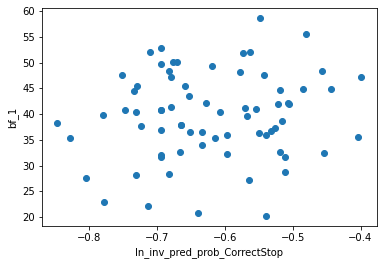

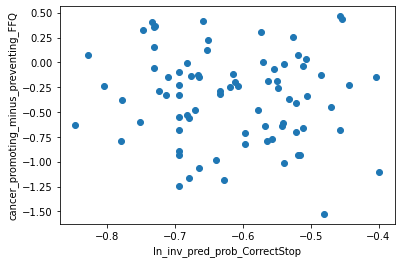

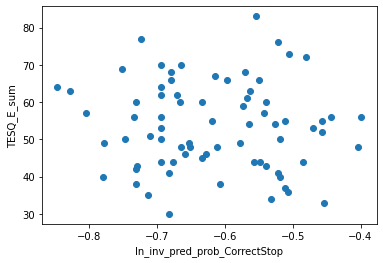

In [24]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



print(prediction,forced_choice_prediction)

#forced_choice_results_dict[mask_name]=forced_choice_results
print_forced_choice_results(forced_choice_results,individual_differences,['ln_inv_pred_prob_CorrectStop'])


SVC_proba_wholebrain = forced_choice_results

#### forced choice prediction performance

I want to find out why those forced choice performance scores are so low. I haven't seen this befroe but the "force choice prediction" is lower than the other scores. need to find out why that is--perhaps there's an error in the forced_choice_prediction scoring.

So we can replicate the forced_choice logic below, using `forced_choice_results['sample_wise']`, then 

In [26]:
forced_choice_results['sample_wise']

,chunks,target_y,pred_y,pred_y_forced_choice,pred_prob_CorrectGo,pred_prob_CorrectStop,ln_inv_pred_prob_CorrectGo,ln_inv_pred_prob_CorrectStop
0,DEV005_1,CorrectGo,CorrectGo,CorrectGo,0.475979,0.524021,-0.646223,-0.742382
1,DEV005_1,CorrectStop,CorrectGo,CorrectStop,0.474099,0.525901,-0.642642,-0.746340
0,DEV006_1,CorrectGo,CorrectGo,CorrectStop,0.405563,0.594437,-0.520140,-0.902479
1,DEV006_1,CorrectStop,CorrectGo,CorrectGo,0.472021,0.527979,-0.638699,-0.750731
0,DEV010_1,CorrectGo,CorrectGo,CorrectStop,0.456703,0.543297,-0.610099,-0.783722
...,...,...,...,...,...,...,...,...
1,DEV216_1,CorrectStop,CorrectStop,CorrectGo,0.593357,0.406643,-0.899820,-0.521959
0,DEV217_1,CorrectGo,CorrectStop,CorrectStop,0.568567,0.431433,-0.840643,-0.564636
1,DEV217_1,CorrectStop,CorrectStop,CorrectGo,0.633142,0.366858,-1.002781,-0.457060
0,DEV218_1,CorrectGo,CorrectGo,CorrectStop,0.455550,0.544450,-0.607979,-0.786250


In [36]:
pred_prob_CG = forced_choice_results['sample_wise'].pred_prob_CorrectGo
target_is_CG = forced_choice_results['sample_wise'].target_y=="CorrectGo"
error = np.abs(target_is_CG-pred_prob_CG) #calculate absolute error
forced_choice_results['sample_wise']['error'] = error
mean_absolute_error = error.mean()

In [37]:
forced_choice_results['sample_wise']

,chunks,target_y,pred_y,pred_y_forced_choice,pred_prob_CorrectGo,pred_prob_CorrectStop,ln_inv_pred_prob_CorrectGo,ln_inv_pred_prob_CorrectStop,error
0,DEV005_1,CorrectGo,CorrectGo,CorrectGo,0.475979,0.524021,-0.646223,-0.742382,0.524021
1,DEV005_1,CorrectStop,CorrectGo,CorrectStop,0.474099,0.525901,-0.642642,-0.746340,0.474099
0,DEV006_1,CorrectGo,CorrectGo,CorrectStop,0.405563,0.594437,-0.520140,-0.902479,0.594437
1,DEV006_1,CorrectStop,CorrectGo,CorrectGo,0.472021,0.527979,-0.638699,-0.750731,0.472021
0,DEV010_1,CorrectGo,CorrectGo,CorrectStop,0.456703,0.543297,-0.610099,-0.783722,0.543297
...,...,...,...,...,...,...,...,...,...
1,DEV216_1,CorrectStop,CorrectStop,CorrectGo,0.593357,0.406643,-0.899820,-0.521959,0.593357
0,DEV217_1,CorrectGo,CorrectStop,CorrectStop,0.568567,0.431433,-0.840643,-0.564636,0.431433
1,DEV217_1,CorrectStop,CorrectStop,CorrectGo,0.633142,0.366858,-1.002781,-0.457060,0.633142
0,DEV218_1,CorrectGo,CorrectGo,CorrectStop,0.455550,0.544450,-0.607979,-0.786250,0.544450


In [39]:
forced_choice_results['sample_wise'].groupby('target_y').error.mean() #mean absolute error

target_y
CorrectGo      0.531402
CorrectStop    0.541330
Name: error, dtype: float64

In [43]:
forced_choice_results['sample_wise']

,chunks,target_y,pred_y,pred_y_forced_choice,pred_prob_CorrectGo,pred_prob_CorrectStop,ln_inv_pred_prob_CorrectGo,ln_inv_pred_prob_CorrectStop,error
0,DEV005_1,CorrectGo,CorrectGo,CorrectGo,0.475979,0.524021,-0.646223,-0.742382,0.524021
1,DEV005_1,CorrectStop,CorrectGo,CorrectStop,0.474099,0.525901,-0.642642,-0.746340,0.474099
0,DEV006_1,CorrectGo,CorrectGo,CorrectStop,0.405563,0.594437,-0.520140,-0.902479,0.594437
1,DEV006_1,CorrectStop,CorrectGo,CorrectGo,0.472021,0.527979,-0.638699,-0.750731,0.472021
0,DEV010_1,CorrectGo,CorrectGo,CorrectStop,0.456703,0.543297,-0.610099,-0.783722,0.543297
...,...,...,...,...,...,...,...,...,...
1,DEV216_1,CorrectStop,CorrectStop,CorrectGo,0.593357,0.406643,-0.899820,-0.521959,0.593357
0,DEV217_1,CorrectGo,CorrectStop,CorrectStop,0.568567,0.431433,-0.840643,-0.564636,0.431433
1,DEV217_1,CorrectStop,CorrectStop,CorrectGo,0.633142,0.366858,-1.002781,-0.457060,0.633142
0,DEV218_1,CorrectGo,CorrectGo,CorrectStop,0.455550,0.544450,-0.607979,-0.786250,0.544450


### Mask

planning_association-test_z_FDR_0.01
2746.3888888888887


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


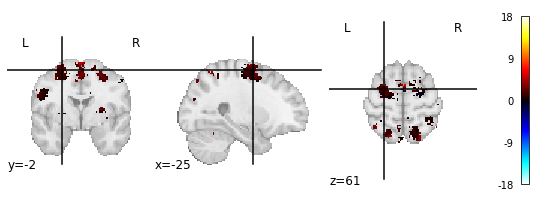

.................................................................................
0.6851851851851852 0.06172839506172839
(0.6851851851851852, 0.06172839506172839)


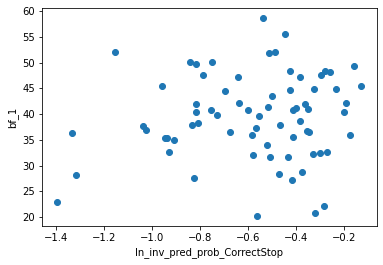

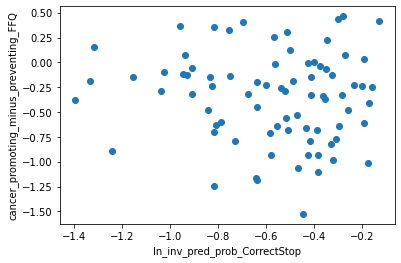

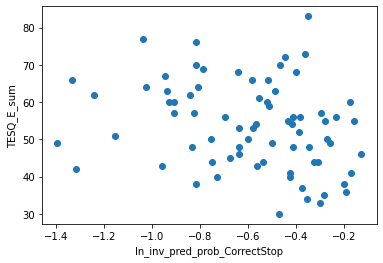

executive function_association-test_z_FDR_0.01
95.46296296296296


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


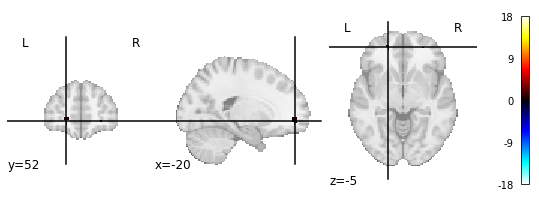

.................................................................................
0.6111111111111112 0.09876543209876543
(0.6111111111111112, 0.09876543209876543)


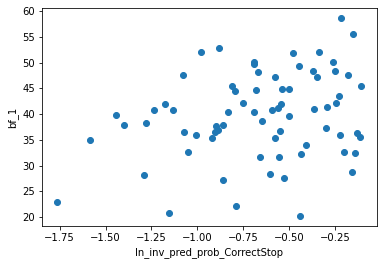

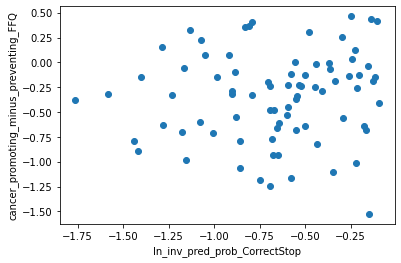

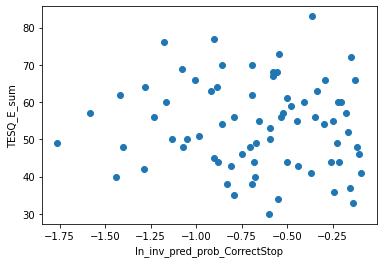

response inhibition_association-test_z_FDR_0.01
1881.9197530864199


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


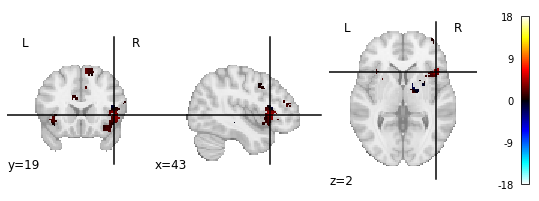

.................................................................................
0.6975308641975309 0.9629629629629629
(0.6975308641975309, 0.9629629629629629)


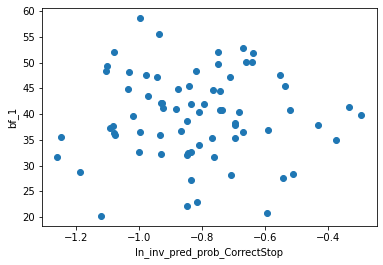

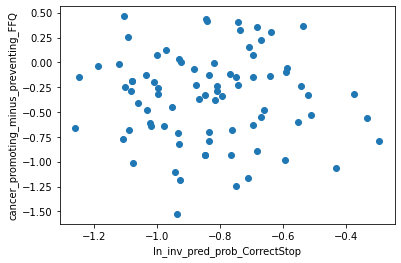

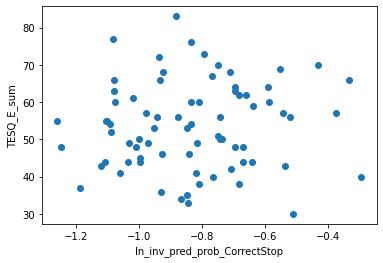

inhibition_association-test_z_FDR_0.01
635.574074074074


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


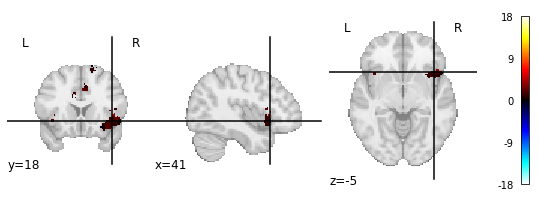

.................................................................................
0.6790123456790124 0.9382716049382716
(0.6790123456790124, 0.9382716049382716)


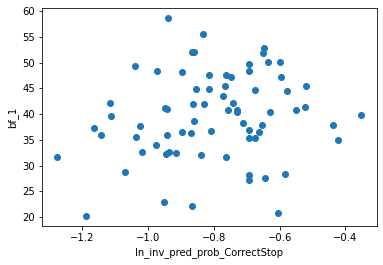

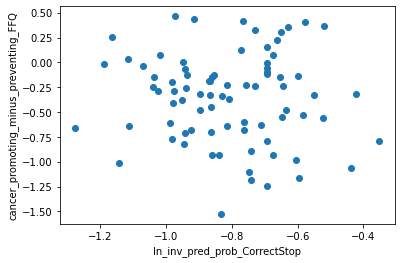

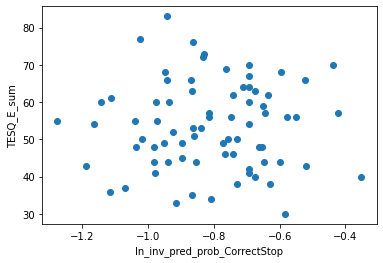

error_association-test_z_FDR_0.01
402.7654320987654


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


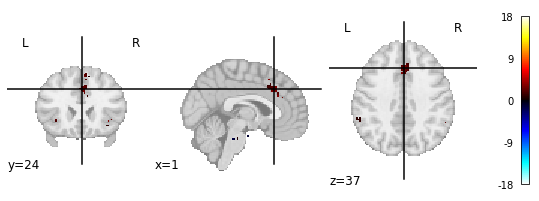

.................................................................................
0.6851851851851852 0.9135802469135802
(0.6851851851851852, 0.9135802469135802)


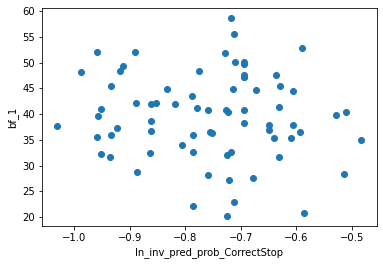

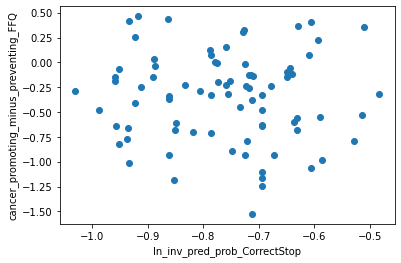

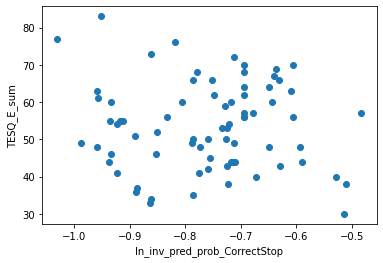

harvardoxford-cortical_prob_Frontal Orbital Cortex
3024.91975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


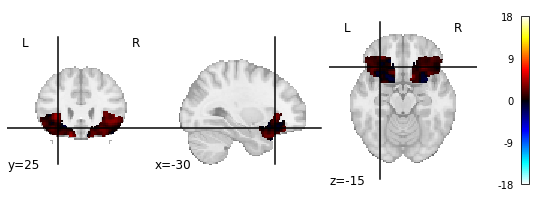

.................................................................................
0.691358024691358 0.9629629629629629
(0.691358024691358, 0.9629629629629629)


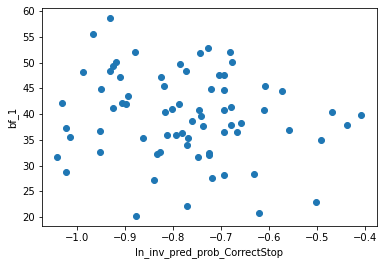

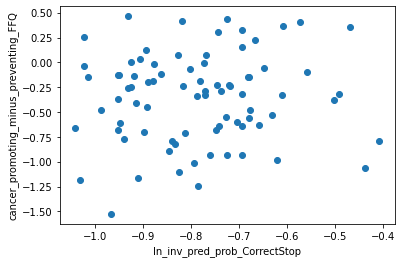

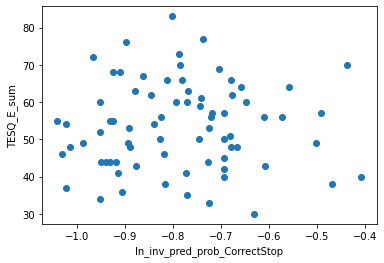

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis
2344.4506172839506


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


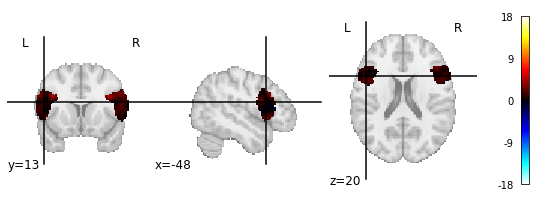

.................................................................................
0.654320987654321 0.2222222222222222
(0.654320987654321, 0.2222222222222222)


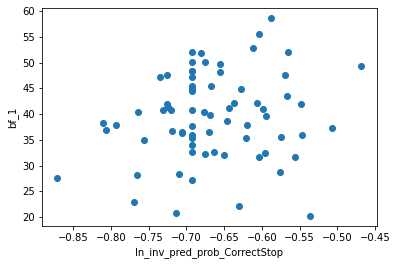

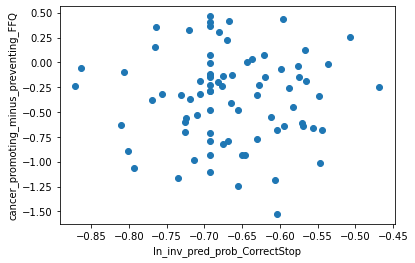

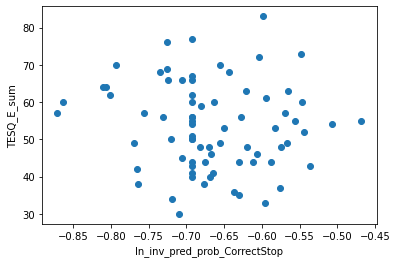

harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis
1943.0246913580247


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


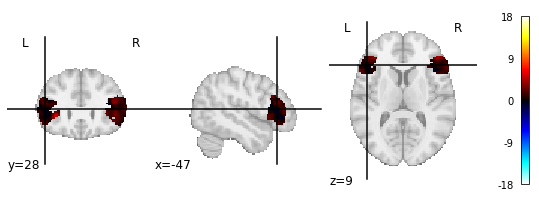

.................................................................................
0.691358024691358 0.7407407407407407
(0.691358024691358, 0.7407407407407407)


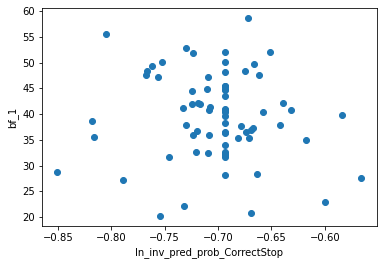

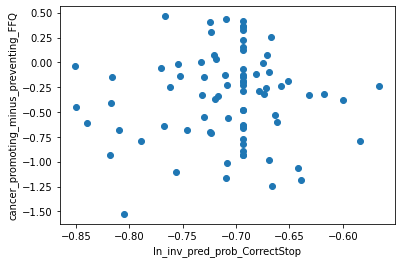

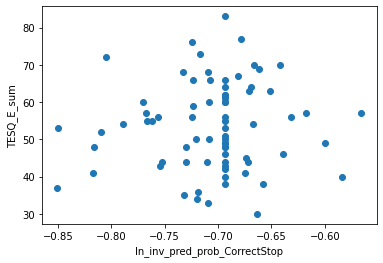

In [40]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGo'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectStop'])


        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        print_forced_choice_results(forced_choice_results,individual_differences,['ln_inv_pred_prob_CorrectStop'])

In [41]:
SVC_proba_masked = forced_choice_results_dict

## Contrast between CorrectStop and CorrectGo...

This does a _regression_ of the beta image on the covariate rather than measuring the discriminability-covariate correlation.

In [44]:
def print_regression_results(forced_choice_results, neural_measures = ['mae']):
    sample_wise_results = forced_choice_results['sample_wise']
#    cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

    individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
    full_dataset_cs = individual_differences.merge(sample_wise_results,how='outer',left_on='subj_wave',right_on='chunks')
    print(full_dataset_cs.columns)
    full_dataset_cs = remove_selected_outliers_mvpa_tesq_study(
        full_dataset_cs,neural_measures = neural_measures,
        show_plot=False)
    
    #https://docs.google.com/presentation/d/10tKHw1VF2WiMapvKXkh2C9VeFHk6iCjTmc0tDTiugOk/edit#slide=id.g11512b79600_0_10
    for nm in neural_measures:
        visualize_corr(nm,'bf_1',full_dataset_cs)
        visualize_corr(nm,'cancer_promoting_minus_preventing_FFQ',full_dataset_cs)
        visualize_corr(nm,'TESQ_E_sum',full_dataset_cs)
    
    

    

In [45]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_stop_go_contrast_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):

        target='SST_SSRT'

        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)

        Brain_Data_allsubs = Brain_Data_allsubs[np.isnan(Brain_Data_allsubs.sa[target].value)==False]

        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,target,standardize=True)

        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_regression(Brain_Data_allsubs,get_predict_and_prob=do_Ridge)
        print("")


        forced_choice_results_dict[mask_name]=forced_choice_results
        print_regression_results(forced_choice_results,['mae'])
        
mae_predictivity_masked = forced_choice_results_dict

In [46]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_stop_go_contrast.pkl"
)

target='SST_SSRT'

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = Brain_Data_allsubs[np.isnan(Brain_Data_allsubs.sa[target].value)==False]

print(mask_name)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs,target,standardize=True)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
plotting.plot_stat_map(masked_preview,vmax=18)
plotting.show()
forced_choice_results = do_regression(Brain_Data_allsubs,get_predict_and_prob=do_Ridge)
print("")


forced_choice_results_dict[mask_name]=forced_choice_results
print_regression_results(forced_choice_results,['mae'])

FileNotFoundError: [Errno 2] No such file or directory: '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_stop_go_contrast.pkl'

In [ ]:
mae_predictivity_wholebrain = forced_choice_results

## Test 2

In [ ]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt_2022_02_26.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

In [ ]:
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)


So actually, probably neural activity explains additional variance in a very straightforward way.

We found some relationships with FFQ. If these hold, it would be interesting to see support from them.

sooo...let's get a record of all the items from test 1 that we want to try running...

In [ ]:
def select_CS_trials(df):
    return(df[df['target_y']=='CorrectStop'])

def select_CS_and_labels(df):
    return(df.loc[:,['chunks','pred_prob_CorrectStop']])

def label_cols(df, prepend):
    df1=df.copy()
    df1.columns = [prepend + c if c!="chunks" else c for c in df.columns]
    return(df1)

In [ ]:
linearSVC_cor_wholebrain_CS_CS = label_cols(prepend="linearSVC_cor_wholebrain_CS_CS", df=select_CS_and_labels(select_CS_trials(LinearSVC_correlation_wholebrain['sample_wise'])))
linearSVC_cor_planning_CS_CS = label_cols(prepend="linearSVC_cor_planning_CS_CS", df=select_CS_and_labels(select_CS_trials(LinearSVC_correlation_masked['planning_association-test_z_FDR_0.01']['sample_wise'])))
SVC_prob_planning_CS_CS = label_cols(prepend="SVC_prob_planning_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_masked['planning_association-test_z_FDR_0.01']['sample_wise'])))
SVC_prob_exec_function_CS_CS = label_cols(prepend="SVC_prob_exec_function_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_masked['executive function_association-test_z_FDR_0.01']['sample_wise'])))
SVC_inhib_CS_CS = label_cols(prepend="SVC_inhib_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_masked['inhibition_association-test_z_FDR_0.01']['sample_wise'])))
SVC_IFG_PT_CS_CS = label_cols(prepend="SVC_IFG_PT_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_masked['harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis']['sample_wise'])))
SVC_wholebrain_CS_CS = label_cols(prepend="SVC_wholebrain_CS_CS", df=select_CS_and_labels(select_CS_trials(SVC_proba_wholebrain['sample_wise'])))

In [ ]:
neural_all = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(
        linearSVC_cor_wholebrain_CS_CS,
        linearSVC_cor_planning_CS_CS),
        SVC_prob_planning_CS_CS),
        SVC_prob_exec_function_CS_CS),
        SVC_inhib_CS_CS),
        SVC_IFG_PT_CS_CS),
        SVC_wholebrain_CS_CS)

In [ ]:
individual_differences['subj_wave'] = individual_differences.subject + "_" + individual_differences.wave.astype(str)

In [ ]:
neural_behavioral = pd.merge(
    neural_all,
    individual_differences,
    left_on='chunks',right_on='subj_wave')



In [ ]:
neural_behavioral.to_csv(ml_data_folderpath + "/analysis_v5_test1.csv")

In [ ]:
ml_data_folderpath

# PES-related

Discriminability

In [ ]:
pes_vars_of_interest  =['RTFS_factor_1','RTFS_factor_2','RTFS_f1_minus_f2', 
                        'SST_PostErrorSlowW1_median','SST_PostErrorSlowW1_mean','SST_pes_mean_limited',
                        'FFQ_v2_Mean_Weighted_Nutrient_Density']

In [ ]:

all_masks = get_failure_masks(ml_data_folderpath)

## PES-related conditions separate

whole-brain:

In [ ]:
np.random.seed(1646100326)

In [ ]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


In [ ]:

forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterCS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingCorrectStop'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterFS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingFailedStop'])


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])


print_forced_choice_results(
    forced_choice_results,
    individual_differences,
    ['ln_inv_pred_prob_CGAfterCS'],
    behavioral_measures = pes_vars_of_interest,
    target_y='CorrectGoFollowingCorrectStop')
print_forced_choice_results(
    forced_choice_results,
    individual_differences,
    ['ln_inv_pred_prob_CGAfterFS'],
    behavioral_measures = pes_vars_of_interest,
    target_y='CorrectGoFollowingFailedStop')

print(prediction,forced_choice_prediction)

In [ ]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)


forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterCS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingCorrectStop'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterFS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingFailedStop'])


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

print(prediction,forced_choice_prediction)

print_forced_choice_results(
    forced_choice_results,
    individual_differences,
    ['ln_inv_pred_prob_CGAfterCS'],
    behavioral_measures = pes_vars_of_interest,
    target_y='CorrectGoFollowingCorrectStop')
print_forced_choice_results(
    forced_choice_results,
    individual_differences,
    ['ln_inv_pred_prob_CGAfterFS'],
    behavioral_measures = pes_vars_of_interest,
    target_y='CorrectGoFollowingFailedStop')

print(prediction,forced_choice_prediction)

In [ ]:
forced_choice_results['sample_wise']

In [ ]:
SVC_proba_wholebrain = forced_choice_results

masked:

In [ ]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_" +
        mask_name
        + ".pkl"
    )
    print(brain_data_filepath)
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_SVC)
        
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterCS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingCorrectStop'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterFS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingFailedStop'])

        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results

        
        print_forced_choice_results(
            forced_choice_results,
            individual_differences,
            ['ln_inv_pred_prob_CGAfterCS'],
            behavioral_measures = pes_vars_of_interest,
            target_y='CorrectGoFollowingCorrectStop')
        print_forced_choice_results(
            forced_choice_results,
            individual_differences,
            ['ln_inv_pred_prob_CGAfterFS'],
            behavioral_measures = pes_vars_of_interest,
            target_y='CorrectGoFollowingFailedStop')

In [ ]:
pes_proba_masked = forced_choice_results_dict

In [ ]:
def select_trials_by_type(df,trial_type):
    return(df[df['target_y']==trial_type])

def select_prob_col_with_label(df,prob_col):
    return(df.loc[:,['chunks',prob_col]])


# def select_CS_trials(df):
#     return(df[df['pred_y_forced_choice']=='CorrectStop'])

# def select_CS_and_labels(df):
#     return(df.loc[:,['chunks','pred_prob_CorrectStop']])

def label_cols(df, prepend):
    df1=df.copy()
    df1.columns = [prepend + c if c!="chunks" else c for c in df.columns]
    return(df1)


In [ ]:
pes_proba_masked['harvardoxford-cortical_prob_Frontal Orbital Cortex']['sample_wise']

In [ ]:
pes_proba_masked.keys()

In [ ]:
CG_p_CS_wholebrain = label_cols(
    select_prob_col_with_label(
    select_trials_by_type(SVC_proba_wholebrain['sample_wise'],'CorrectGoFollowingCorrectStop'),
    "pred_prob_CorrectGoFollowingCorrectStop"
),'CG_p_CS_wholebrain_')

CG_p_FS_wholebrain = label_cols(
    select_prob_col_with_label(
    select_trials_by_type(SVC_proba_wholebrain['sample_wise'],'CorrectGoFollowingFailedStop'),
    "pred_prob_CorrectGoFollowingFailedStop"
),'CG_p_FS_wholebrain_')

CG_p_FS_emotion_regulation = label_cols(
    select_prob_col_with_label(
    select_trials_by_type(
        pes_proba_masked['emotion regulation_association-test_z_FDR_0.01']['sample_wise']
        ,'CorrectGoFollowingFailedStop'),
    "pred_prob_CorrectGoFollowingFailedStop"
),'CG_p_FS_Frontal Orbital Cortex_')

CG_p_FS_Frontal_Orbital_Cortex = label_cols(
    select_prob_col_with_label(
    select_trials_by_type(
        pes_proba_masked['harvardoxford-cortical_prob_Frontal Orbital Cortex']['sample_wise']
        ,'CorrectGoFollowingFailedStop'),
    "pred_prob_CorrectGoFollowingFailedStop"
),'CG_p_FS_Frontal Orbital Cortex_')

# CG_p_CS_ACC = label_cols(
#     select_prob_col_with_label(
#     select_trials_by_type(
#         pes_proba_masked['harvardoxford-cortical_prob_Cingulate Gyrus, anterior division']['sample_wise']
#         ,'CorrectGoFollowingCorrectStop'),
#     "pred_prob_CorrectGoFollowingCorrectStop"
# ),'CG_p_CS_ACC_')

# CG_p_CS_Negative_Affect = label_cols(
#     select_prob_col_with_label(
#     select_trials_by_type(
#         pes_proba_masked['negative affect_association-test_z_FDR_0.01']['sample_wise']
#         ,'CorrectGoFollowingCorrectStop'),
#     "pred_prob_CorrectGoFollowingCorrectStop"
# ),'CG_p_CS_negative affect_')

In [ ]:
neural_all = pd.merge(pd.merge(pd.merge(
        CG_p_CS_wholebrain,
        CG_p_FS_wholebrain),
        CG_p_FS_emotion_regulation),
        CG_p_FS_Frontal_Orbital_Cortex)

In [ ]:
neural_behavioral = pd.merge(
    neural_all,
    individual_differences,
    left_on='chunks',right_on='subj_wave')



In [ ]:
neural_behavioral.to_csv(ml_data_folderpath + "/analysis_v5_pes_test1.csv")